In [4]:
# Import CVX and numpy libraries
import cvxpy as cvx
import numpy as np
import random
import networkx as nx
import matplotlib.pyplot as plt
import snap

Performing extra analysis with respect to network theory and clustering coefficients

In [ ]:
def generate(n,npoints):
    # Set the limits
    origA = np.full((n+1,n),-5.)
    rangA = np.full((n+1,n), 10.)
    origP = np.full((npoints,n),-5.)
    rangP = np.full((npoints,n), 10.)

    # Construct the anchor points
    a = np.random.rand(n+1,n)
    a = origA + np.multiply(a,rangA)

    # Construct the sensor points
    p = np.random.rand(npoints,n)
    p = origP + np.multiply(p,rangP)

    adjacency = np.full((npoints+n+1,npoints+n+1),-1.)

    if(n > 1):
        minConstr = 3
        maxConstr = 4
        minPointConstr = 2
        minAnchConstr = 2
    else:
        minConstr = 2
        maxConstr = 3
        minPointConstr = 1
        minAnchConstr = 1

    anchList = [i for i in range(n+1)]
    pointList = [i for i in range(npoints)]
    off = n + 1

    for i in range(npoints):
        random.shuffle(anchList)
        random.shuffle(pointList)
        # Set anchor constraints, between 1 and 3
        numAnch = random.randint(minAnchConstr,minConstr)
        for l in range(numAnch):
            adjacency[anchList[l],i+off] = np.linalg.norm(a[anchList[l]] - p[i])
            adjacency[i+off,anchList[l]] = adjacency[anchList[l],i+off]
        #print(numAnch)
        # Count number of constraints already set for this point
        countConstr = 0
        for l in range(npoints+off):
            if(adjacency[l,i+off] > 0):
                countConstr = countConstr + 1
        # Set point constraints, between 0 and 3
        if(minConstr - countConstr >= 0):
            numPoint = random.randint(minConstr-countConstr,3)
            count = numPoint
            l = 0
            while(count > 0 and l < len(pointList)):
                if(pointList[l] != i):
                    countConstr = 0
                    for k in range(npoints+off):
                        if(adjacency[k,pointList[l]+off] > 0):
                            countConstr = countConstr + 1
                    if(countConstr < maxConstr):
                        adjacency[pointList[l]+off,i+off] = \
                            np.linalg.norm(p[pointList[l]] - p[i])
                        adjacency[i+off,pointList[l]+off] = \
                            adjacency[pointList[l]+off,i+off]
                        count = count - 1
                l = l + 1
    return [a, p, adjacency]

def generate_inside_hull(n,npoints):
    # Set the limits
    origA = np.full((n+1,n),-5.)
    rangA = np.full((n+1,n), 10.)
    origP = np.full((npoints,n),-5.)
    rangP = np.full((npoints,n), 10.)
    
    if(n == 1):
        a = np.array([-6., 6.])
    elif(n == 2):
        a = np.array([[-6., 15.], [-6., -15.], [8., 0.]])
    elif(n == 3):
        a = np.array([[-6., 15.,-10.], [-6., -15.,-10.], \
                      [8., 0., -10.], [0., 0., 10.]])
    # Construct the sensor points
    p = np.random.rand(npoints,n)
    p = origP + np.multiply(p,rangP)

    adjacency = np.full((npoints+n+1,npoints+n+1),-1.)

    if(n > 1):
        minConstr = 3
        maxConstr = 4
        minPointConstr = 2
        minAnchConstr = 2
    else:
        minConstr = 2
        maxConstr = 3
        minPointConstr = 1
        minAnchConstr = 1

    anchList = [i for i in range(n+1)]
    pointList = [i for i in range(npoints)]
    off = n + 1

    for i in range(npoints):
        random.shuffle(anchList)
        random.shuffle(pointList)
        # Set anchor constraints, between 1 and 3
        numAnch = random.randint(minAnchConstr,minConstr)
        for l in range(numAnch):
            adjacency[anchList[l],i+off] = np.linalg.norm(a[anchList[l]] - p[i])
            adjacency[i+off,anchList[l]] = adjacency[anchList[l],i+off]
        #print(numAnch)
        # Count number of constraints already set for this point
        countConstr = 0
        for l in range(npoints+off):
            if(adjacency[l,i+off] > 0):
                countConstr = countConstr + 1
        # Set point constraints, between 0 and 3
        if(minConstr - countConstr >= 0):
            numPoint = random.randint(minConstr-countConstr,3)
            count = numPoint
            l = 0
            while(count > 0 and l < len(pointList)):
                if(pointList[l] != i):
                    countConstr = 0
                    for k in range(npoints+off):
                        if(adjacency[k,pointList[l]+off] > 0):
                            countConstr = countConstr + 1
                    if(countConstr < maxConstr):
                        adjacency[pointList[l]+off,i+off] = \
                            np.linalg.norm(p[pointList[l]] - p[i])
                        adjacency[i+off,pointList[l]+off] = \
                            adjacency[pointList[l]+off,i+off]
                        count = count - 1
                l = l + 1
    return [a, p, adjacency]

In [244]:
#Plot the graph
def plotGraph(n, npoints, adjacency, a, p):
    if(n == 2):
        G=nx.Graph()

        for i in range(n+1):
            G.add_node(i,pos=a[i])

        for i in range(npoints):
            G.add_node(n+1+i,pos=p[i])

        pos=nx.get_node_attributes(G,'pos')

        nx.draw_networkx_nodes(G,pos,
                               nodelist=[i for i in range(n+1)],
                               node_color='r',
                               node_size=50,
                               alpha=0.8)
        nx.draw_networkx_nodes(G,pos,
                               nodelist=[i for i in range(n+1,npoints+n+1)],
                               node_color='b',
                               node_size=50,
                               alpha=0.8)
        for i in range(npoints+n+1):
            for j in range(n+1,npoints+n+1):
                if(adjacency[j,i] > 0.):
                    G.add_edge(i,j)

        nx.draw_networkx_edges(G,pos)
        plt.draw()  # pyplot draw()

In [241]:
res = []
#Random constraints on the anchor points that we are interested in
tests = [(3, 4, 3), (3, 4, 2), (3, 4, 1), (3, 4, 0), (2, 3, 2), \
         (2, 3, 1), (2, 3, 0), (1, 2, 1), (1, 2, 0), (0, 1, 0)]
#Perform 200 trials
for w in range(200):
    if(w % 50 == 0):
        print "Iteration: ", w
        
    #2 dimensions with the number of sensors ranging from
    #1 to 20 in our problem
    n = 2
    npoints = np.random.randint(1, 20)
    
    #Choose a random anchor constraint
    c = random.choice(tests)
    
    #Randomize whether we generate the points randomly or 
    #all inside the hull. This is to capture varying clustering
    #coefficients
    HullOrNot = random.randint(0, 1)
    if HullOrNot:
        (a, p, adjacency) = generate_inside_hull(n, npoints, c[0], c[1], c[2])
    else:
        (a, p, adjacency) = generate(n, npoints, c[0], c[1], c[2])
    if q % 10 == 0:
        (a, p, adjacency) = generate(n, npoints, 3, 4, 3)
    if q % 5 == 0:
        (a, p, adjacency) = generate_inside_hull(n, npoints, 3, 4, 3)

    # Compute the Euclidian distances to the anchor points
    adjSize = len(p) + len(a)
    asize = len(a)
    d = []
    
    #Compute the d variable from the adjacency matrix
    for i in range(adjSize):
        for j in range(adjSize):
            if(j > i and adjacency[i][j] > 0 and i < asize):
                d.append((adjacency[i][j], j - asize, i, True))
            elif(j > i and adjacency[i][j] > 0):
                d.append((adjacency[i][j], i - asize, j - asize, False))

    T = n + npoints

    z = cvx.Semidef(T)
    
    #Construct the constraints for our problem
    eyeConstraint = []
    anchorConstraints = []
    pointConstraints = []

    for i in range(n):
        temp = np.zeros((T,T))
        temp[i][i] = 1
        eyeConstraint.append(temp)

    temp = np.zeros((T,T))
    for i in range(n):
        for j in range(n):
            temp[i][j] = 1
    eyeConstraint.append(temp)

    for (distance, i, j, truth) in d:
        if truth:
            temp = np.zeros(npoints)
            temp[i] = -1.
            anchorConstraints.append((np.outer(np.append(a[j], temp),\
                                               np.append(a[j], temp)),\
                                                distance))
        else:
            tempi = np.zeros(npoints)
            tempj = np.zeros(npoints)
            tempi[i] = 1.
            tempj[j] = 1.
            temp = tempi - tempj
            corner = np.zeros(n)
            temp = np.append(corner, temp)
            pointConstraints.append((np.outer(temp,temp), distance))

    matConstraints = anchorConstraints + pointConstraints

    #Another empty states list
    states = []

    #Perform SDP and solve the problem
    cost = cvx.norm(0)

    #The four constraints in the SDP relaxation problem
    #Note that the last constraint forces z to be SPD
    constr = []

    for i, mat in enumerate(eyeConstraint):
        if i < len(eyeConstraint) - 1:
            constr.append(cvx.sum_entries(cvx.mul_elemwise(mat, z)) == 1)
        else:
            constr.append(cvx.sum_entries(cvx.mul_elemwise(mat, z)) == n)

    for i, mat in enumerate(matConstraints):
        constr.append(cvx.sum_entries(cvx.mul_elemwise(mat[0], z)) ==  mat[1] ** 2)

    constr.append(z >> 0)

    #Add the constraints and cost function
    states.append(cvx.Problem(cvx.Minimize(cost), constr))

    #Solve the SDP relaxation problem
    prob = sum(states)
    prob.solve();    
    
    #Using this solution, compute the RMSE value for this trial
    SDPSolution = z.value.A[0:n, n:n + npoints].transpose()
    RMSE = np.linalg.norm(SDPSolution - p) ** 2
    
    #Construct the graph in SNAP
    Graph = snap.TUNGraph.New()

    for i in range(npoints + len(a)):
        Graph.AddNode(i)

    for (distance, i, j, truth) in d:
        if truth:
            Graph.AddEdge(i, j +  npoints)
        else:
            Graph.AddEdge(i, j)

    #Compute the clustering coefficients, don't include
    #any graphs that have coefficients of 0 (poorly 
    #generated graphs)
    GraphClustCoeff = snap.GetClustCf(Graph, -1)
    if GraphClustCoeff > 0.001:
        res.append([RMSE, GraphClustCoeff])

Iteration:  0
Iteration:  50
Iteration:  100
Iteration:  150


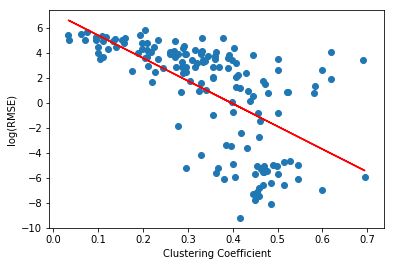

In [245]:
#Plot the result of our findings
x = np.asarray([elem for elem in zip(*res)[1]])
y = np.log(np.asarray([elem for elem in zip(*res)[0]]))

plt.scatter(x, y)
plt.xlabel("Clustering Coefficient")
plt.ylabel("log(RMSE)")
#Regression line
m, b = np.polyfit(x, y, 1)
plt.plot(x, m*x + b, '-', color = 'r')
plt.show()

Below, we will generate some examples of clustering coefficients along with plots of the graphs

0.536666666667


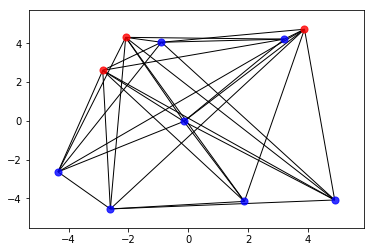

In [206]:
n = 2
npoints = 7
c = random.choice(tests)
HullOrNot = random.randint(0, 1)
(a, p, adjacency) = generate(n, npoints, 3, 4, 3)

# Compute the Euclidian distances to the anchor points
Graph = snap.TUNGraph.New()

for i in range(npoints + len(a)):
    Graph.AddNode(i)

for (distance, i, j, truth) in d:
    if truth:
        Graph.AddEdge(i, j +  npoints)
    else:
        Graph.AddEdge(i, j)

GraphClustCoeff = snap.GetClustCf(Graph, -1)
print GraphClustCoeff
plotGraph(n, npoints, adjacency, a, p)

0.276923076923


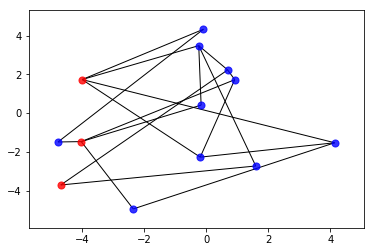

In [229]:
n = 2
npoints = 10
c = random.choice(tests)
HullOrNot = random.randint(0, 1)
(a, p, adjacency) = generate(n, npoints, 1, 2, 1)

# Compute the Euclidian distances to the anchor points
Graph = snap.TUNGraph.New()

for i in range(npoints + len(a)):
    Graph.AddNode(i)

for (distance, i, j, truth) in d:
    if truth:
        Graph.AddEdge(i, j +  npoints)
    else:
        Graph.AddEdge(i, j)

GraphClustCoeff = snap.GetClustCf(Graph, -1)
print GraphClustCoeff
plotGraph(n, npoints, adjacency, a, p)